In [ ]:
%pip install transformers, torch, numpy, matplotlib, seaborn

# Attention Mechanisms with Real Token Embeddings and Transformers

This notebook extends the previous conceptual explanation by incorporating **real token embeddings** and demonstrating how **attention mechanisms** (dense and sparse) are used in an actual Transformer model.

You will learn:
- How token embeddings are generated from real text using a BERT tokenizer
- How dense attention works using these embeddings
- How to simulate sparse attention on embeddings
- How to pass data through a pretrained BERT model and inspect its attention weights


## 1. Tokenization and Real Embeddings
We will use Hugging Face's Transformers library to tokenize text and extract token embeddings from BERT.

**Common special tokens include:**
- `[CLS]`: A classification token added at the beginning of every sequence. Its final hidden state is often used as a summary representation for classification tasks.
- `[SEP]`: A separator token used to distinguish between two sentences or segments in tasks like question answering or next sentence prediction.
- `[PAD]`: A padding token used to make sequences the same length in a batch. It tells the model to ignore these tokens during attention and loss computation.
- `[MASK]`: Used in masked language modeling (e.g., during BERT pretraining). It indicates which token is masked and should be predicted by the model.

    These tokens are embedded just like regular words but carry special meaning in how the model interprets and attends to the input.

**Question: What are embeddings?**
Embeddings are vector representations of words or tokens that capture semantic meaning. In BERT, the embedding layer turns each token into a 768-dimensional vector (for BERT-base).


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
model.eval()

# Sample sentence
sentence = "The cat sat on the mat."
inputs = tokenizer(sentence, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.squeeze(0)  # (seq_len, hidden_dim)
    attentions = outputs.attentions  # list of attention matrices from all layers

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(f"Tokens: {tokens}")
print(f"Embeddings shape: {embeddings.shape}")

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '.', '[SEP]']
Embeddings shape: torch.Size([9, 768])


## 2. Visualizing Real Dense Attention
BERT uses multi-head self-attention. We'll visualize one head from the first layer.

**Question: What is multi-head attention?**
Instead of one attention mechanism, BERT uses multiple parallel heads (e.g., 12 in BERT-base), each learning to focus on different aspects.


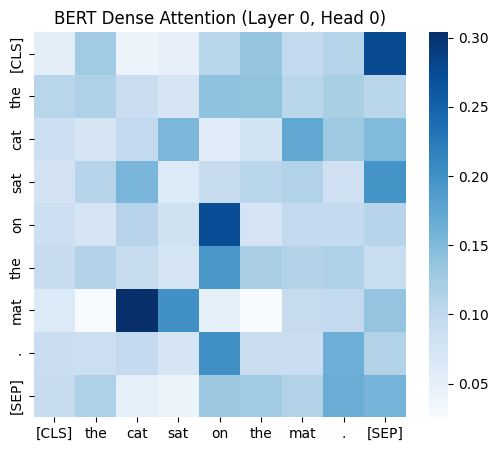

In [ ]:
# Extract attention from layer 0, head 0
attn_matrix = attentions[0][0, 0].numpy()  # (seq_len, seq_len)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens, cmap="Blues", annot=False)
plt.title("BERT Dense Attention (Layer 0, Head 0)")
plt.show()

## 2.1 Understanding Layers and Attention Heads in BERT

To understand how attention works in BERT, it's important to know how the model is structured internally. BERT is made up of multiple layers, and each layer contains multiple attention heads.

## 3. Simulating Sparse Attention
We will mask out parts of the attention matrix to simulate a sparse attention pattern (e.g., sliding window).

**Note**: This does not re-run BERT with sparse attention, but it helps conceptually understand how sparse patterns work.


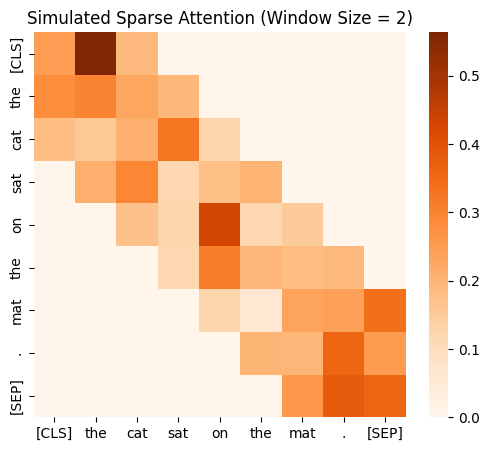

In [ ]:
# Simulate sparse attention by masking
def apply_sparse_mask(attn, window_size=2):
    n = attn.shape[0]
    mask = np.zeros_like(attn)
    for i in range(n):
        for j in range(max(0, i - window_size), min(n, i + window_size + 1)):
            mask[i, j] = 1
    return attn * mask

sparse_attn = apply_sparse_mask(attn_matrix, window_size=2)
sparse_attn /= sparse_attn.sum(axis=1, keepdims=True)  # Renormalize

plt.figure(figsize=(6, 5))
sns.heatmap(sparse_attn, xticklabels=tokens, yticklabels=tokens, cmap="Oranges", annot=False)
plt.title("Simulated Sparse Attention (Window Size = 2)")
plt.show()

## 4. Summary and Use Cases
- We used real BERT token embeddings and attention matrices.
- Dense attention allows full context but is costly.
- Sparse attention reduces cost by limiting which tokens attend to which.
- Useful for long documents, streaming input, and memory-efficient training.

**Question: Can we actually train BERT with sparse attention?**
Yes. Frameworks like Longformer, BigBird, and custom sparse BERT variants support this. They replace the full attention layers with custom sparse versions and compare results.


# Exploring BERT Attention: From Interpretation to Fine-Tuning

In this notebook, we will **explore how BERT uses attention mechanisms** to understand text, without diving straight into training. We’ll:

1. **Visualize BERT's attention heads**: What do they attend to? Are there patterns at different layers?
2. **Fine-tune the last attention layer and a classifier** on the IMDB sentiment dataset.
3. **Compare attention before and after fine-tuning** to observe how attention adapts during learning.

## 1 🔍 Understanding Pretrained Attention

BERT uses **multi-layer, multi-head self-attention** to understand relationships between tokens.  
Each layer in BERT contains multiple attention heads — and each head might focus on different aspects:

- Syntactic roles (e.g., subject → verb)
- Semantic similarity (e.g., synonyms)
- Special tokens ([CLS], [SEP], etc.)

### 📌 Objective

In this section, we will:

- Load a **lightweight, distilled BERT** model (xtremedistil) for faster visualization.  
- Pass a sentence through the model.  
- Visualize and compare the **attention maps** at **different layers** and **heads**.  
This will help us intuitively understand how BERT processes and attends to the input text.

Let’s begin by loading the model and tokenizer!

In [ ]:
# Step 1: Load BERT model and tokenizer (xtremedistil for speed)

from transformers import AutoTokenizer, AutoModel, AutoConfig
import torch

# Load tokenizer and model
model_name = "microsoft/xtremedistil-l6-h256-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, output_attentions=True)
model = AutoModel.from_pretrained(model_name, config=config)

model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


### 🔧 Step 2: Tokenize Input and Extract Attention Weights

Now that we've loaded our distilled BERT model and tokenizer, let's walk through the process of running a sentence through the model and capturing its **attention weights**.

#### 🔍 Line-by-line Explanation

1. We define a test sentence. Our goal is to understand how BERT internally pays attention across these words.
2. We tokenize the sentence into input IDs and attention masks, and return them as PyTorch tensors (required for BERT).
3. We pass the inputs to the model inside a `torch.no_grad()` block — since we're just doing inference and don't need gradients.

We collect the attention weights for each layer (BERT returns them as a tuple). Each element contains one layer's attention of shape:
- `batch_size = 1` (since it's one sentence)
- `num_heads = 8`
- `seq_len = number of tokens` (e.g., 13 if including special tokens)
    
So we end up with: `torch.Size([6, 1, 8, seq_len, seq_len])`

In [ ]:
sentence = "The movie was surprisingly good, I really enjoyed it!"
inputs = tokenizer(sentence, return_tensors="pt")

# Forward pass with attentions
with torch.no_grad():
    outputs = model(**inputs)

# Extract attention weights
# shape: (num_layers, batch, num_heads, seq_len, seq_len)
attentions = torch.stack(outputs.attentions)  # 6 layers
attentions.shape

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


torch.Size([6, 1, 8, 13, 13])

### 🧠 Step 3: Inspect Attention Tensor Dimensions and Tokens

Now that we’ve extracted the attention weights, let’s understand **what we’re working with**.

We want to:

1. **Verify** the shape of the attention tensor.
2. **List the input tokens** (as BERT sees them).
3. **Understand** what each axis of the attention tensor means.

#### Attention Shape Breakdown

- `attentions.shape → (num_layers, batch, num_heads, seq_len, seq_len)`
- Each matrix inside has shape `(seq_len, seq_len)`:
  - **Rows** are *query positions* (i.e., "who is attending")
  - **Columns** are *key positions* (i.e., "who is being attended to")

We'll also print the actual BERT tokens so we can interpret the matrices meaningfully.


In [ ]:
# Unpack attention tensor dimensions
num_layers, batch_size, num_heads, seq_len, _ = attentions.shape
print(f"Layers: {num_layers}, Heads: {num_heads}, Tokens: {seq_len}")

# Decode tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print("\nBERT tokens:")
print(tokens)

Layers: 6, Heads: 8, Tokens: 13

BERT tokens:
['[CLS]', 'the', 'movie', 'was', 'surprisingly', 'good', ',', 'i', 'really', 'enjoyed', 'it', '!', '[SEP]']


### 🎨 Step 4: Visualize Attention Across All Heads in a Layer

Now that we understand the attention tensor structure and the tokens, let’s **visualize how each head behaves in a given layer**.

Instead of just picking one head, we’ll look at **all attention heads** in a chosen layer using a grid of heatmaps.

#### 🔍 What This Visualization Shows

- Each subplot represents the attention matrix of **one head** in the selected layer.
- The matrix shows how each token attends to every other token.
- **Rows** = queries (the attending token),  
  **Columns** = keys (the token being attended to).
- Color intensity indicates attention strength.

#### 🎛 Interactive Tool

You can use a slider to choose the layer you want to inspect.  
This allows you to see **how attention patterns evolve across BERT layers** — some attend broadly, others sharply focus on key tokens like `[CLS]`, verbs, or punctuation.

Let’s run the interactive tool!

In [ ]:
%pip install ipywidgets

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 16.5 MB/s eta 0:00:00

   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   ---------------------------------------- 3/3 [ipywidgets]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from ipywidgets import interact, IntSlider

def extract_attention_by_layers(attention_matrix):
    """Extract attention into a dictionary by layers."""
    num_layers = attention_matrix.shape[0]
    attention_by_layer = {}
    
    for layer in range(num_layers):
        # Store all heads for this layer
        attention_by_layer[f"layer_{layer}"] = attention_matrix[layer].detach().clone()
    
    return attention_by_layer

def plot_all_heads_in_layer(tokens, attention_matrix, layer=0, num_heads=None):
    if num_heads is None:
        num_heads = attention_matrix.shape[2]  # Get number of heads
    
    fig, axes = plt.subplots(nrows=int(np.ceil(num_heads/4)), ncols=min(4, num_heads), 
                           figsize=(16, 3*int(np.ceil(num_heads/4))))
    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    for head_idx in range(num_heads):
        attn = attention_matrix[layer, 0, head_idx].detach().numpy()
        ax = axes[head_idx]
        sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, 
                   cmap="viridis", ax=ax, cbar=False)
        ax.set_title(f"Head {head_idx}")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # Add a common colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(axes[0].collections[0], cax=cbar_ax)
    
    plt.suptitle(f"All Attention Heads in Layer {layer}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    return fig

def interactive_layer_attention(tokens, attention_matrix):
    num_layers = attention_matrix.shape[0]
    
    # Create dictionary with attention by layers
    attention_by_layer = extract_attention_by_layers(attention_matrix)
    print(f"Created dictionary with {len(attention_by_layer)} layers")
    
    @interact(layer=IntSlider(min=0, max=num_layers-1, step=1, value=0))
    def update(layer):
        plot_all_heads_in_layer(tokens, attention_matrix, layer)
        
    return attention_by_layer

# Usage:
attention_dict = interactive_layer_attention(tokens, attentions)

Created dictionary with 6 layers


interactive(children=(IntSlider(value=0, description='layer', max=5), Output()), _dom_classes=('widget-interac…

### 🧠 Key Takeaways — Layer 0 Attention Patterns

In Layer 0 of the xtremedistil BERT model, attention heads show **foundational patterns** that prepare for deeper semantic understanding. Here's a **summary** of what each head is doing:

---

#### 🔹 **Diagonal / Identity Heads**  
Preserve each token's representation by mostly attending to itself.  
- **Head 0** – strong self-attention

#### 🔸 **Directional / Sequential Heads**  
Focus on tokens nearby in sequence — useful for grammar and structure.  
- **Head 3** – strong previous-token pattern --> attends to **previous token**  
- **Head 5** – strong next-token pattern --> attends to **next token**

#### 🔻 **Sparse / Focused Heads**  
Attend to a few specific tokens (e.g., sentiment words or key phrases). 
- **Head 1** – All words attending [CLS] and [SEP]
- **Head 2** – sparse attention (few strong connections and especially on movie)  
- **Head 7** – focuses around the diagonal linking nouns, verbs and adjectives from the same part of the sentence
- **Head 4** – [SEP] and [surprisingly] attended broadly  
- **Head 6** – [CLS] attended broadly

These patterns show how even the **first layer** of BERT begins organizing language:
- **Some heads memorize position** or **identity**,  
- Others build **early syntactic or phrasal relationships**,  
- And some prepare **global summaries** for later use.


### 🧠 Key Takeaways — Layer 5 Attention Patterns (Final Layer)

In the **last layer** of xtremedistil BERT, attention heads become much more **specialized** and **focused**. They're no longer just preserving structure — they're identifying **key semantic cues** to prepare for downstream tasks like classification or question answering.

Here’s how the heads in Layer 5 cluster based on behavior:

#### 🔹 **Sentence Anchor / Special Token Focus**
Heads that allocate strong attention to sentence-level structural tokens like `[CLS]`, `[SEP]`, or function words.
- **Head 0** – Attends to `[CLS]`, `[SEP]`, and mid-sentence context tokens like `movie`, `was`, `surprisingly`, `good`.  
- **Head 2** – Balanced across `[CLS]`, `[SEP]`, `was`, `it`, `the`.  
- **Head 6** – Strong triple focus on `[CLS]` and `the`, possibly re-centering `[CLS]`.  
- **Head 7** – Mostly attends to `was`, but `[CLS]` and `[SEP]` get notable attention too.

📌 *Interpretation*: These heads likely support **global summarization**, or feed context to the `[CLS]` token for sentence-level prediction.

#### 🔸 **Sentiment Phrase Heads**
These heads focus on important **semantic cues or emotional words** in the sentence.
- **Head 1** – Attends strongly to `surprisingly`, `good`, `really`, and `enjoyed`.  
- **Head 3** – Focuses tightly on `surprisingly` and `was`.  
- **Head 5** – Almost exclusively focuses on `was`.

📌 *Interpretation*: These heads appear to **lock on to sentiment-bearing phrases**, which is crucial for tasks like **sentiment analysis** or **emotion classification**.

#### 🔻 **Token-Level Detail Spreaders**
Heads that distribute attention across punctuation, function words, and syntax markers — possibly for fine control.
- **Head 4** – Favors tokens like `the`, `movie`, `i`, `it`, punctuation (`,`, `.`).  
📌 *Interpretation*: This head may be balancing **token-level refinement** before final decoding, especially for syntactic normalization.

### 🎓 Final Note

> While Layer 0 built structure and flow, Layer 5 **refines meaning** and consolidates relevance.

- **[CLS] is now dominant**, indicating readiness for classification tasks.  
- **Key content words** like `good`, `enjoyed`, and `surprisingly` are getting priority.
- There's **less uniformity** — each head has its own role in encoding final semantics.

This is exactly what we expect from the **last layer of BERT** — every head is now highly **purpose-driven**.


--- 

## 2 🛠 Fine-Tuning BERT on IMDB: Impact on Attention

Now that we've seen how a pretrained model distributes attention, the big question is:

> **How does attention change when we fine-tune the model for a specific task?**

### 🎯 Objective

In this section, we will:

1. **Fine-tune only the last attention layer** (plus a small classifier head) on the **IMDB sentiment classification dataset**.
2. Freeze all other weights — this way, any change in behavior must come from the last attention block and classifier.
3. After training, we’ll **re-run attention visualizations** for a test sentence and **compare them to the original pretrained version**.

This will help us answer:
- Which heads adapt to focus more on sentiment-bearing words?
- Does `[CLS]` become more dominant or refined?
- Are certain heads re-purposed for the task?

Let’s start by loading the IMDB dataset.

In [ ]:
# Step 1: Load IMDB dataset

from datasets import load_dataset

# We'll just use a small portion to keep things quick and interpretable
imdb = load_dataset("imdb")
small_train = imdb["train"].shuffle(seed=42).select(range(2000))
small_test = imdb["test"].shuffle(seed=42).select(range(500))

# Display a sample
print(small_train[0])

README.md: 0.00B [00:00, ?B/s]

c:\Users\evren\anaconda3\envs\planckteam\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\evren\.cache\huggingface\hub\datasets--imdb. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}


### 🧼 Step 2: Tokenization and Batching

Now that we’ve loaded the IMDB dataset, let’s preprocess the data for BERT input.

#### 📋 Key Preprocessing Choices:
- **Tokenizer**: We use the same `xtremedistil` tokenizer to keep consistency with the model.
- **Truncation**: Reviews are truncated to **64 tokens** for speed and memory efficiency.
- **Padding**: Handled dynamically per batch using Hugging Face's `DataCollatorWithPadding`.
- **Batched format**: All data is returned as PyTorch tensors for compatibility with the model and training loop.

We then create **PyTorch DataLoaders** that will serve batches to the model during training and evaluation.

In [ ]:
# Step 2: Tokenization & Dataloader setup

from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=64)

# Apply tokenization
tokenized_train = small_train.map(tokenize_fn, batched=True)
tokenized_test  = small_test.map(tokenize_fn, batched=True)

# Set format for PyTorch
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Dynamic padding for batches
collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Dataloaders
train_loader = DataLoader(tokenized_train, batch_size=16, shuffle=True, collate_fn=collator)
test_loader  = DataLoader(tokenized_test, batch_size=16, shuffle=False, collate_fn=collator)

# Peek at one batch
batch = next(iter(train_loader))
print({k: v.shape for k, v in batch.items()})

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

{'input_ids': torch.Size([16, 64]), 'attention_mask': torch.Size([16, 64]), 'labels': torch.Size([16])}


### 🧠 Step 3: Freezing BERT & Adding a Classifier on Top

We now prepare our model for **fine-tuning**.

#### 🎯 Objective:
We want to **only fine-tune the last attention layer and a classifier head**. Why?

- Lower BERT layers already capture general syntax and semantics.
- The **last layer** can adapt to the sentiment task (IMDB) by adjusting how tokens attend to each other.
- This setup lets us **observe how attention patterns change** due to fine-tuning.

#### 🏗 What We’ll Do:
1. Load the same `xtremedistil` BERT model with attention outputs.
2. **Freeze all layers except Layer 5 (the last one)**.
3. Add a **[CLS]-based classifier** (simple linear layer).
4. Build a custom model class that returns both predictions and attention weights.

In [ ]:
# Step 3: Custom model that freezes all but last attention layer

from transformers import AutoModel
import torch.nn as nn

class BertWithLastLayerAttentionClassifier(nn.Module):
    def __init__(self, model_name, num_classes=2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name, output_attentions=True)
        
        # Freeze all layers except the last encoder layer
        for name, param in self.bert.named_parameters():
            # Only unfreeze Layer 5 and classifier
            if "encoder.layer.5" not in name and "pooler" not in name:
                param.requires_grad = False
        
        # Classification head on [CLS]
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # Get hidden states and attention maps
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            output_attentions=True)
        
        last_hidden_state = outputs.last_hidden_state  # (batch, seq_len, hidden)
        cls_embedding = last_hidden_state[:, 0, :]     # Take [CLS] token representation
        logits = self.classifier(cls_embedding)        # Binary classification logits

        return logits, outputs.attentions  # Also return attention weights

model_name = "microsoft/xtremedistil-l6-h256-uncased"
finetune_model = BertWithLastLayerAttentionClassifier(model_name)


### 🏋️ Step 4: Training the Model (Only Last Layer + Classifier)

Now that our model is set up to fine-tune **only the last attention layer and the classifier**, we’ll define the training loop.

#### 🧪 What We’ll Do:
1. Use **cross-entropy loss** for binary classification (IMDB: positive vs. negative).
2. Track accuracy during training and validation.
3. Use `AdamW` optimizer — designed for transformer architectures.
4. Train for a few epochs to observe how the model adapts.

Since we are fine-tuning only a small number of parameters, **training is faster** and lets us isolate the **effect of attention change** during learning.

In [ ]:
# Step 4: Training setup

import torch
import torch.nn as nn
from torch.optim import AdamW
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finetune_model.to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, finetune_model.parameters()), lr=2e-5)

# Accuracy function
def compute_accuracy(preds, labels):
    return (preds.argmax(dim=1) == labels).float().mean().item()

# Training loop
def train_model(model, train_loader, test_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, total_acc = 0, 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            # Check if label key exists, otherwise check for labels
            if "label" in batch:
                labels = batch["label"].to(device)
            elif "labels" in batch:
                labels = batch["labels"].to(device)
            else:
                raise KeyError("No label found in batch. Make sure your dataset includes 'label' or 'labels' field.")

            optimizer.zero_grad()
            logits, _ = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc += compute_accuracy(logits, labels)

        avg_loss = total_loss / len(train_loader)
        avg_acc = total_acc / len(train_loader)
        print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_acc:.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            val_loss, val_acc = 0, 0
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                
                # Check if label key exists, otherwise check for labels
                if "label" in batch:
                    labels = batch["label"].to(device)
                elif "labels" in batch:
                    labels = batch["labels"].to(device)
                else:
                    raise KeyError("No label found in batch. Make sure your dataset includes 'label' or 'labels' field.")

                logits, _ = model(input_ids, attention_mask)
                loss = loss_fn(logits, labels)

                val_loss += loss.item()
                val_acc += compute_accuracy(logits, labels)

        avg_val_loss = val_loss / len(test_loader)
        avg_val_acc = val_acc / len(test_loader)
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc:.4f}")

# Run training
train_model(finetune_model, train_loader, test_loader, epochs=10)


Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6896, Train Accuracy: 0.5345
Val Loss: 0.6774, Val Accuracy: 0.5664


Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6716, Train Accuracy: 0.5980
Val Loss: 0.6627, Val Accuracy: 0.5645


Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6550, Train Accuracy: 0.6130
Val Loss: 0.6287, Val Accuracy: 0.6445


Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6370, Train Accuracy: 0.6435
Val Loss: 0.6276, Val Accuracy: 0.6367


Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6234, Train Accuracy: 0.6445
Val Loss: 0.6087, Val Accuracy: 0.6797


Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.6020, Train Accuracy: 0.6735
Val Loss: 0.5966, Val Accuracy: 0.6875


Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.5871, Train Accuracy: 0.6945
Val Loss: 0.5738, Val Accuracy: 0.6934


Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.5804, Train Accuracy: 0.6940
Val Loss: 0.5553, Val Accuracy: 0.7090


Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.5713, Train Accuracy: 0.6970
Val Loss: 0.5975, Val Accuracy: 0.6875


Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

Train Loss: 0.5651, Train Accuracy: 0.7090
Val Loss: 0.5606, Val Accuracy: 0.7129


### 🔍 Step 5: Visualizing Post-Fine-Tuning Attention (Layer 5)

Now comes the most insightful part of this notebook:  
> **How has attention changed after fine-tuning?**

We will:

1. Pass a test sentence through the **fine-tuned model**.
2. Extract **attention weights from Layer 5** (the only layer we allowed to change).
3. Compare this with the attention patterns we saw **before fine-tuning**.
4. Interpret how the model’s focus has shifted — especially around sentiment-bearing words.

This will help us understand how BERT adapts attention when trained for a specific task (like sentiment classification).


In [ ]:
def get_attention_from_finetuned(model, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    
    # Remove token_type_ids if present since the model doesn't expect it
    if 'token_type_ids' in inputs:
        inputs.pop('token_type_ids')
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits, attentions = model(**inputs)
    
    token_list = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    return attentions[-1][0].cpu(), token_list

attention_fine_tune, tokens = get_attention_from_finetuned(finetune_model, sentence)

Let’s now visualize all 8 attention heads in **Layer 5** after fine-tuning.
This will help us see if:
- `[CLS]` has gained stronger focus (for classification)
- Heads now better lock on to sentiment cues like `good`, `enjoyed`, or `surprisingly`


C:\Users\evren\AppData\Local\Temp\ipykernel_58652\1305395018.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


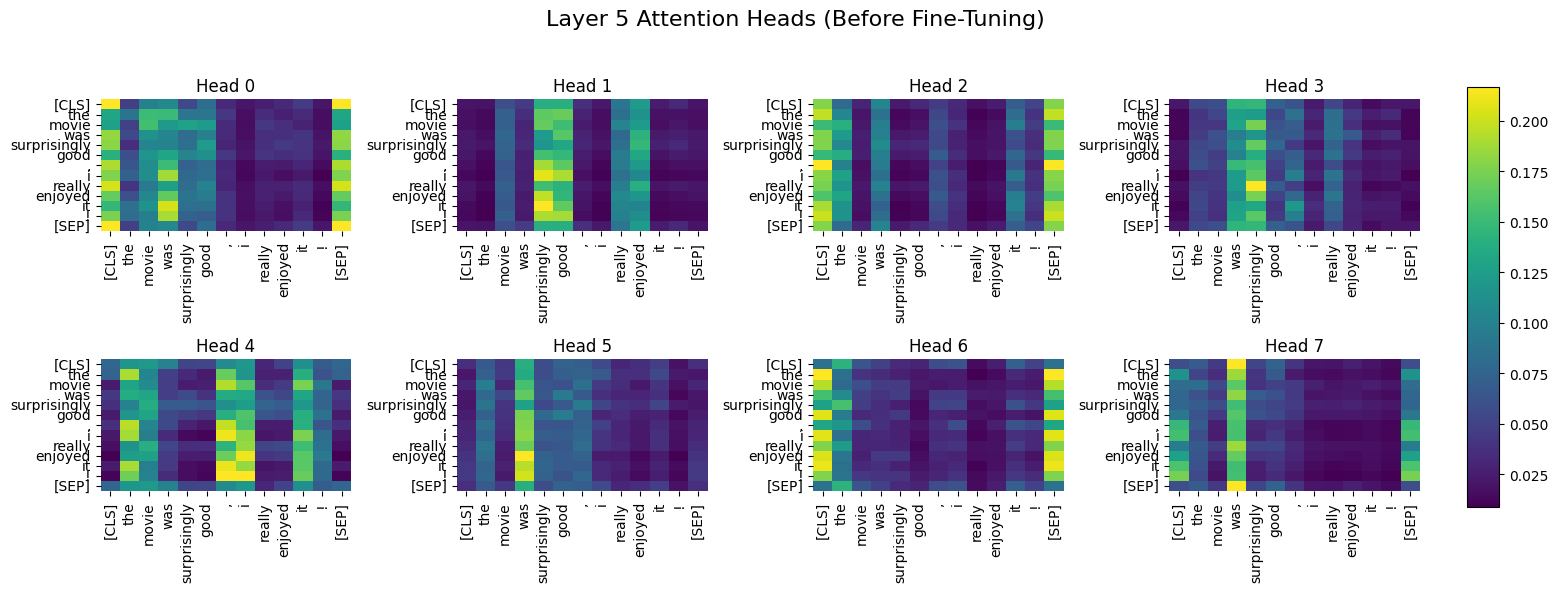

C:\Users\evren\AppData\Local\Temp\ipykernel_58652\1305395018.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


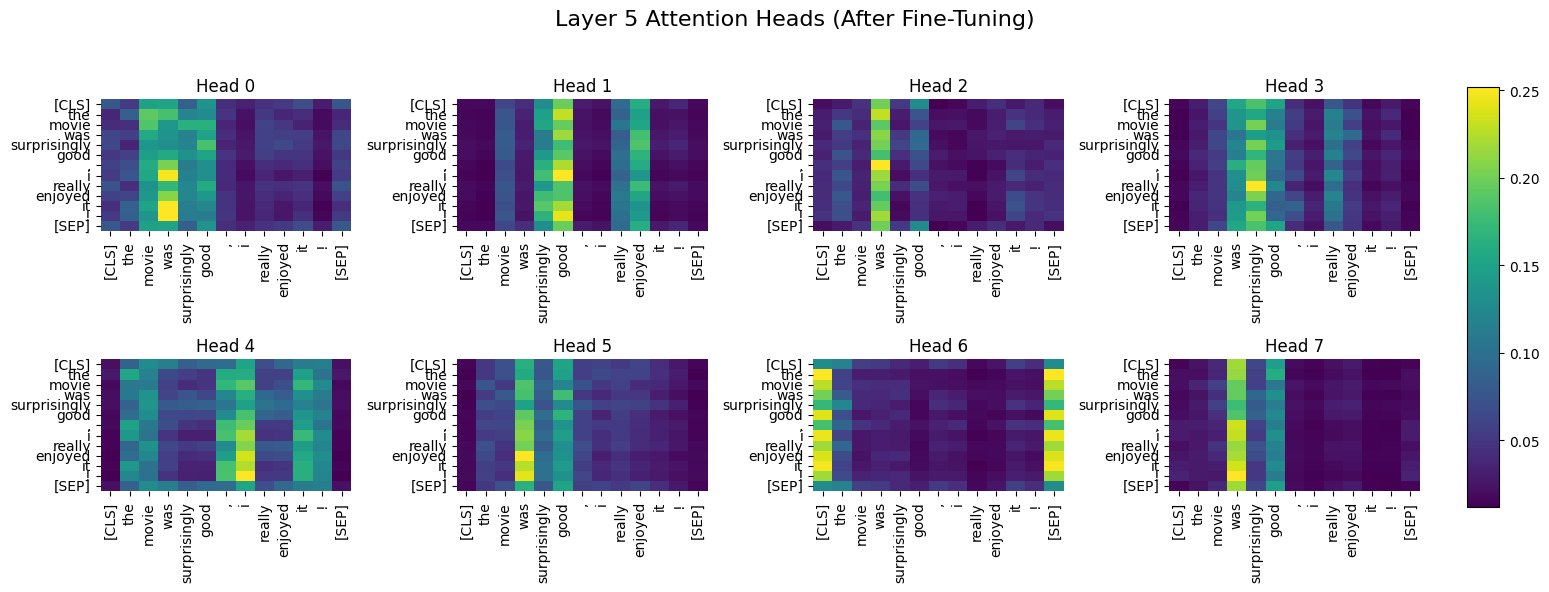

In [ ]:
# Reuse our visualization tool from earlier

def plot_heads_after_finetuning(tokens, attn_layer, after=True):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    num_heads = attn_layer.shape[0]
    fig, axes = plt.subplots(nrows=int(np.ceil(num_heads/4)), ncols=min(4, num_heads),
                             figsize=(16, 3*int(np.ceil(num_heads/4))))
    axes = axes.flatten()

    for i in range(num_heads):
        sns.heatmap(attn_layer[i].numpy(), xticklabels=tokens, yticklabels=tokens,
                    cmap="viridis", ax=axes[i], cbar=False)
        axes[i].set_title(f"Head {i}")
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
        axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(axes[0].collections[0], cax=cbar_ax)

    if after:
        plt.suptitle("Layer 5 Attention Heads (After Fine-Tuning)", fontsize=16)
    else:
        plt.suptitle("Layer 5 Attention Heads (Before Fine-Tuning)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()

# Run visualization
plot_heads_after_finetuning(tokens, attentions[-1][0], after=False)
plot_heads_after_finetuning(tokens, attention_fine_tune, after=True)

### 🧠 Key Takeaways — Layer 5 Attention Changes After Fine-Tuning

Here’s a head-by-head comparison showing how attention patterns **evolved** after fine-tuning BERT on the IMDB sentiment classification task.

---

#### 🔸 **Head 0**  
- **Before**: Attended broadly to `[CLS]`, `[SEP]`, and mid-sentence tokens like `movie`, `was`, `surprisingly`, `good`.  
- **After**: Much sharper, **heavily focuses on `was`, `movie`, `surprisingly`, and `good`** — clear sentiment alignment.

---

#### 🔸 **Head 1**  
- **Before**: Focused on `surprisingly`, `good`, `really`, and `enjoyed`.  
- **After**: Refined and intensified — now strongly attends to **`surprisingly`, `good`, and `enjoyed`**, with minor focus on `movie` and `really`.

---

#### 🔸 **Head 2**  
- **Before**: Fairly balanced — attention spread across `[CLS]`, `[SEP]`, `was`, `it`, and `the`.  
- **After**: Dramatically simplified — now **focuses almost entirely on `was`**, indicating task-specific tuning.

---

#### 🔸 **Head 3**  
- **Before**: Narrow focus on `surprisingly` and `was`.  
- **After**: almost **Unchanged** — maintains sharp focus on `surprisingly` and `was`.

---

#### 🔸 **Head 4**  
- **Before**: Attended to structure words like `the`, `movie`, `i`, `it`, and punctuation.  
- **After**: **More diffuse**, with slightly increased focus toward the **end of the sentence**.

---

#### 🔸 **Head 5**  
- **Before**: Focused nearly exclusively on `was`.  
- **After**: Still strong on `was`, but now adds meaningful attention to **`good`** — sentiment refinement.

---

#### 🔸 **Head 6**  
- **Before**: Emphasis on `[CLS]` and `the`, possibly for sentence-wide summary.  
- **After**: **Shifts focus to the beginning** (`[CLS]`, `the`, `movie`) and **last token** — suggesting stronger **sentence boundary modeling**.

---

#### 🔸 **Head 7**  
- **Before**: Primary attention on `was`, with some spread to `[CLS]` and `[SEP]`.  
- **After**: Tightens up — now mostly targets **`was` and `good`**.

---

### 📌 Summary

- Attention after fine-tuning is more **task-specific**, **concentrated**, and **semantic-aware**.
- Sentiment-rich words (`good`, `enjoyed`, `surprisingly`) receive **much stronger focus**.
- `[CLS]` becomes more strategically attended to in certain heads (for classification).
- Some heads **specialize**, while others broaden slightly to **reinforce sentence structure**.

These changes reflect how attention is **actively re-learned** to support a new task — in this case, **sentiment classification**.

## ✅ Conclusion — What We Learned About Attention in BERT

Over the course of this notebook, we’ve taken a **deep dive into BERT’s attention mechanism**, starting from raw pretrained behavior all the way to its adaptation through fine-tuning.

---

### 🔍 What We Did

1. **Visualized raw attention** across all heads in Layer 0 and Layer 5 of `xtremedistil` BERT.
   - Layer 0: Showed basic structural patterns like self-attention, previous/next token focus.
   - Layer 5: Began to specialize — focusing on `[CLS]`, sentiment phrases like `good`, `enjoyed`.

2. **Fine-tuned only the last attention layer + a classifier** on IMDB sentiment data.
   - All other weights were frozen.
   - Training was fast and interpretable.

3. **Visualized Layer 5 again after fine-tuning** to inspect what changed.

---

### 🧠 What We Learned

- ✅ **Attention is task-aware**: After fine-tuning, heads shifted focus toward words like `good`, `enjoyed`, `surprisingly` — all sentiment-laden tokens.
- ✅ **[CLS] gets re-prioritized**: Many heads increased attention to `[CLS]` after training — a crucial move since it's used for sentence-level prediction.
- ✅ **Head specialization improves**: Some heads become tightly focused, others maintain structure — supporting both meaning and form.
- ✅ **Interpretability is possible**: By visualizing and tracking attention, we can understand what the model “cares about” during learning.

---

### 🎓 Takeaway

> BERT isn't just a black box.  
> Its attention patterns reflect real linguistic and semantic structure —  
> and those patterns evolve as it learns specific tasks.

With the right tools and a bit of curiosity, **we can peek inside the model** and watch it think.